# PyTorch Tutorial Series

[pytorch2](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/pytorch2.ipynb)

In [27]:
%reset -sf

In [28]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

Suppose one has data that consists of an independent vector a dependent vector $x_i$ and $y_i$ ($i$ is the ith value in the data set). For example:

- $x_i$ is the height of the th person, and  is their weight (predict weight using height)
- $x_i$ is a picture of a handwritten digit, and  is the digit itself (predict numbers from hand written numbers)
- $x_i$ is a CT scan of a patient, and  are the corresponding pixels corresponding to tumours (my research)

The goal of a neural network is as follows. Define a function $f$ that depends on parameters  that makes predictions
$$
\hat{y}_i = f(x_i;a)
$$
One wants to make $\hat{y}_i$ (the predictions) and $y_i$ (the true values) as close as possible by modifying the values of . What does as close as possible mean? This depends on the task. In general, one defines a similarity function (or **Loss** function) $L(y,\hat{y}_i)$. The more similar all the $\hat{y}_i$s and $y_i$s are, the smaller $L$ should be. For example 1 above, this could be as simple as
 
$$
L(y,\hat{y}_i)=\sum_i(y_i-\hat{y}_i)^2
$$

In [29]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

- So $x_1=(6,2)$, $x_2=(5,2)$ , $\ldots$
- So $y_1=1$, $y_2=5$, $\dots$

We want to find a function $f$ that depends on $a$ parameters that lets us get from $x$  to $y$.

**Idea**:

1. First multiply each element in $x$ by a $8\times2$ matrix (this is 16 parameters $a_i$)
1. Then multiply each element in $x$ by a $1 \times 8$ matrix (this is 8 parameters $a_i$)

Define a matrix (takes in a 2d vector and returns a 8d vector).

- **IMPORTANT**: When the matrix is created, it is initially created with random values.

In [30]:
M1 = nn.Linear(2,8,bias=False)
M1

Linear(in_features=2, out_features=8, bias=False)

If one passes in a vector $x$ (the dataset) where each element $x_i$ (an instance) is a 2d vector, $M$ will apply the same matrix multiplication to each element $x_i$.

In [31]:
M1(x)

tensor([[ 0.9294, -0.5561,  1.2425,  2.5758,  1.3992, -1.7487, -4.2304, -0.0229],
        [ 0.5890, -0.3536,  1.2033,  2.0617,  0.9714, -1.3275, -3.7537,  0.1988],
        [-1.3292,  0.7859,  1.5501, -0.2490, -1.3237,  0.7467, -2.5318,  1.7396],
        [-0.9564,  0.5592,  3.2963,  2.0725, -0.5083, -0.6127, -7.4473,  2.3704]],
       grad_fn=<MmBackward0>)

We can chain this with a second matrix $M2$

In [32]:
M2 = nn.Linear(8,1, bias=False)
M2

Linear(in_features=8, out_features=1, bias=False)

In [33]:
M2(M1(x)).squeeze()

tensor([-2.7316, -2.3255, -0.8484, -3.7275], grad_fn=<SqueezeBackward0>)

In [34]:
y

tensor([1., 5., 2., 5.])

The weights of the matrices $M1$ and $M2$ consitute the weights $a$ of the network defined above. In order to optimize for these weights, we first construct our network $f$ as follows:

In [35]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

Constructing the network using a subclass of the nn.Module allows the parameters of the network to be conveniently stored. This will be useful later when we need to adjust them.

In [36]:
f = MyNeuralNet()

Pass in data to the network.

In [37]:
yhat = f(x)
yhat

tensor([-2.4931, -2.0885, -0.5028, -3.0286], grad_fn=<SqueezeBackward0>)

In [38]:
y

tensor([1., 5., 2., 5.])

## Adjusting $a$ so that $\hat{y}$ and $y$ are similar

Now we define the loss function $L$, which provides a metric of similarity between $y$ and $\hat{y}$. In this case, we will use the mean squared error loss function:

In [39]:
L = nn.MSELoss()
L(y,yhat)

tensor(33.2929, grad_fn=<MseLossBackward0>)

Confirming it is doing the same as the regular mean-squared error:

In [40]:
torch.mean((y-yhat)**2)

tensor(33.2929, grad_fn=<MeanBackward0>)

Note that $L$ depends on $a$, since our predictions $\hat{y}$
 depend on the parameters of the network $a$. In this sense, $L-L(a)$ . **The main idea behind machine learning** is to compute
$$
\frac{\partial L}{\partial a_i}
$$
for each parameter $a_i$ of the network. Then we adjust each parameter as follows:
$$
a_i \rightarrow a_i - \ell\frac{\partial L}{\partial a_i}
$$
where $\ell$ is the learning rate.

**Example**: A loss function that only depends on one parameter:

![title](./img/loss.png)

The idea is to do this over and over again, until one reaches a minimum for $L$ . This is called **gradient descent**.

- Each pass of the full data set $x$ is called an **epoch**. In this case, we are evaluating $\partial L/\partial a_i$ on the entire dataset $x$ each time we iterate $a_i \rightarrow a_i - \ell\frac{\partial L}{\partial a_i}$, so each iteration corresponds to an epoch.

The SGD (meaning stochastic gradient descent) takes in all model parameters $a$ along with the learning rate $\ell$.

In [41]:
opt = SGD(f.parameters(), lr=0.001)

Adjust the parameters over and over:

In [42]:
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

Plot $L(a)$ as a function of number of iterations

Text(0.5, 0, 'Epochs')

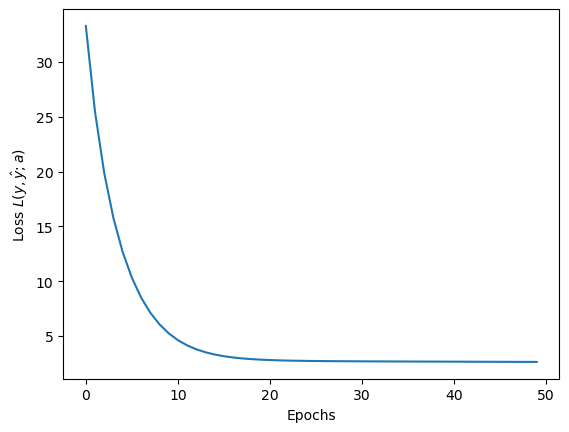

In [43]:
plt.plot(losses)
plt.ylabel('Loss $L(y,\hat{y};a)$')
plt.xlabel('Epochs')

This is as close as we can make the model $f$ predict $y$ from $x$:

In [44]:
f(x)

tensor([3.2905, 2.8312, 1.2614, 4.8192], grad_fn=<SqueezeBackward0>)

In [45]:
y

tensor([1., 5., 2., 5.])